# Transaction Data Analysis

This notebook analyzes transaction patterns and creates a graph structure for money laundering detection.

In [1]:
!pip install polars
!pip install networkx
!pip install matplotlib
!pip install igraph

## Setup

Install required library.

In [2]:
import polars as pl
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig

# df = pl.read_csv('data/HI-Small_Trans.csv')
# Try lazy frame
df = pl.read_csv('data/HI-Small_Trans.csv')

# Sample only 10% of full data for memory management, commented out if want full data
df = df.sample(fraction=0.10, with_replacement=False, seed=42).lazy()

G = nx.DiGraph()
SG = nx.DiGraph()

## Load Data

Read transaction data from CSV file.

In [3]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
str,i64,str,i64,str,f64,str,f64,str,str,i64
"""2022/09/01 14:51""",122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
"""2022/09/02 12:05""",70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
"""2022/09/07 22:23""",14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
"""2022/09/02 15:44""",14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
"""2022/09/01 00:28""",12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
"""2022/09/06 20:48""",124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
"""2022/09/02 01:05""",70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
"""2022/09/09 12:46""",12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


In [4]:
df = df.with_columns(
    pl.col('Timestamp').str.strptime(pl.Datetime, format='%Y/%m/%d %H:%M')
)

## Data Preparation

Convert timestamp column to datetime format.

In [5]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
datetime[μs],i64,str,i64,str,f64,str,f64,str,str,i64
2022-09-01 14:51:00,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
2022-09-02 12:05:00,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
2022-09-07 22:23:00,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
2022-09-02 15:44:00,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
2022-09-01 00:28:00,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
2022-09-06 20:48:00,124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
2022-09-02 01:05:00,70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
2022-09-09 12:46:00,12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


Disregard transaction with Payment Format "Reinvesment"

In [6]:
df = df.filter(pl.col("Payment Format") != "Reinvestment")

In [7]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
datetime[μs],i64,str,i64,str,f64,str,f64,str,str,i64
2022-09-01 14:51:00,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
2022-09-02 12:05:00,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
2022-09-07 22:23:00,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
2022-09-02 15:44:00,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
2022-09-01 00:28:00,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
2022-09-06 20:48:00,124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
2022-09-02 01:05:00,70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
2022-09-09 12:46:00,12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


## Temporal View Graph Initialization

### Create Nodes

Build graph nodes from transactions with ID, sender, receiver, time, amount, and label.

In [8]:
nodes = df.with_row_index("node_id").select([
    pl.col("node_id"),
    pl.col("Account").alias("f_i"),                # From
    pl.col("Account_duplicated_0").alias("b_i"),   # Beneficiary
    pl.col("Timestamp").alias("t_i"),              # Time
    pl.col("Amount Received").alias("a_i"),        # Amount
    pl.col("Is Laundering")                        # Ground truth
])

In [9]:
nodes.collect().head()

node_id,f_i,b_i,t_i,a_i,Is Laundering
u32,str,str,datetime[μs],f64,i64
0,"""808376670""","""808763050""",2022-09-01 14:51:00,165.58,0
1,"""100428660""","""800C08F10""",2022-09-02 12:05:00,1000.0,0
2,"""8035A5A50""","""8035CB140""",2022-09-07 22:23:00,4449.0,0
3,"""8028B20E0""","""80B5A8EF0""",2022-09-02 15:44:00,24022.22,0
4,"""803109B90""","""80A633740""",2022-09-01 00:28:00,2777.01,0


Adding nodes df into nx graph

In [10]:
# for row in nodes.collect().to_dicts():
#     G.add_node(row["node_id"], 
#                f_i=row["f_i"], 
#                b_i=row["b_i"], 
#                t_i=row["t_i"], 
#                a_i=row["a_i"], 
#                is_laundering=row["Is Laundering"])

In [11]:
# Sample some nodes to inspect
# sample_nodes = list(G.nodes)[:5]
# for node in sample_nodes:
#     print(f"Node {node}: {G.nodes[node]}")

### Create Edges

Connect transactions where one receiver becomes the sender in another transaction.

In [12]:
edges = nodes.join(
    nodes,
    left_on="b_i", 
    right_on="f_i",
    suffix="_d",
    how="inner"
).rename({"node_id": "v_s", "node_id_d": "v_d"})

In [13]:
edges.collect()

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64
99295,"""100428810""","""808376670""",2022-09-10 12:26:00,94.14,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
225193,"""8076829F0""","""808376670""",2022-09-02 18:32:00,1537.16,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
280904,"""100428810""","""808376670""",2022-09-04 08:28:00,55.19,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
300146,"""100428810""","""808376670""",2022-09-02 01:56:00,55.19,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
13375,"""80571C290""","""100428660""",2022-09-09 06:35:00,529.2,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0
…,…,…,…,…,…,…,…,…,…,…
451074,"""805836AE0""","""1004286A8""",2022-09-09 16:27:00,3503.46,0,459752,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0
454084,"""803BA4C60""","""1004286A8""",2022-09-02 13:23:00,1370.04,0,459752,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0
69627,"""801F49CC0""","""8085123D0""",2022-09-08 00:56:00,1543.08,0,459753,"""80F2F2D50""",2022-09-09 12:46:00,320.56,0


In [14]:
timedelta = pl.duration(hours=24)

### Filter Edges

Keep only edges where the second transaction occurs within 24 hours after the first.

In [15]:
edges = edges.filter(
    (pl.col("t_i_d") > pl.col("t_i")) & 
    (pl.col("t_i_d") < pl.col("t_i") + timedelta)
)

adding edges to graph G

In [16]:
# for row in edges.select(["v_s", "v_d", "t_i", "t_i_d"]).collect().to_dicts():
#     print(row)
#     break

### Temporal View Results

Display final nodes and edges.

In [17]:
print(nodes.collect())

shape: (459_756, 6)
┌─────────┬───────────┬───────────┬─────────────────────┬──────────┬───────────────┐
│ node_id ┆ f_i       ┆ b_i       ┆ t_i                 ┆ a_i      ┆ Is Laundering │
│ ---     ┆ ---       ┆ ---       ┆ ---                 ┆ ---      ┆ ---           │
│ u32     ┆ str       ┆ str       ┆ datetime[μs]        ┆ f64      ┆ i64           │
╞═════════╪═══════════╪═══════════╪═════════════════════╪══════════╪═══════════════╡
│ 0       ┆ 808376670 ┆ 808763050 ┆ 2022-09-01 14:51:00 ┆ 165.58   ┆ 0             │
│ 1       ┆ 100428660 ┆ 800C08F10 ┆ 2022-09-02 12:05:00 ┆ 1000.0   ┆ 0             │
│ 2       ┆ 8035A5A50 ┆ 8035CB140 ┆ 2022-09-07 22:23:00 ┆ 4449.0   ┆ 0             │
│ 3       ┆ 8028B20E0 ┆ 80B5A8EF0 ┆ 2022-09-02 15:44:00 ┆ 24022.22 ┆ 0             │
│ 4       ┆ 803109B90 ┆ 80A633740 ┆ 2022-09-01 00:28:00 ┆ 2777.01  ┆ 0             │
│ …       ┆ …         ┆ …         ┆ …                   ┆ …        ┆ …             │
│ 459751  ┆ 813B87B71 ┆ 813B87B71 ┆ 2022-09-0

In [18]:
print(edges.select(["v_s", "v_d", "t_i", "t_i_d"]).collect())

shape: (350_964, 4)
┌────────┬────────┬─────────────────────┬─────────────────────┐
│ v_s    ┆ v_d    ┆ t_i                 ┆ t_i_d               │
│ ---    ┆ ---    ┆ ---                 ┆ ---                 │
│ u32    ┆ u32    ┆ datetime[μs]        ┆ datetime[μs]        │
╞════════╪════════╪═════════════════════╪═════════════════════╡
│ 15720  ┆ 1      ┆ 2022-09-02 09:51:00 ┆ 2022-09-02 12:05:00 │
│ 17905  ┆ 1      ┆ 2022-09-02 10:00:00 ┆ 2022-09-02 12:05:00 │
│ 50608  ┆ 1      ┆ 2022-09-02 07:18:00 ┆ 2022-09-02 12:05:00 │
│ 77968  ┆ 1      ┆ 2022-09-02 07:35:00 ┆ 2022-09-02 12:05:00 │
│ 78253  ┆ 1      ┆ 2022-09-02 02:02:00 ┆ 2022-09-02 12:05:00 │
│ …      ┆ …      ┆ …                   ┆ …                   │
│ 231812 ┆ 459751 ┆ 2022-09-06 02:34:00 ┆ 2022-09-06 20:48:00 │
│ 217176 ┆ 459752 ┆ 2022-09-02 00:29:00 ┆ 2022-09-02 01:05:00 │
│ 259236 ┆ 459752 ┆ 2022-09-02 00:08:00 ┆ 2022-09-02 01:05:00 │
│ 348774 ┆ 459752 ┆ 2022-09-02 00:44:00 ┆ 2022-09-02 01:05:00 │
│ 424825 ┆ 459752 ┆ 

## Second Order Graph Creation

### Edge creation

create a second order graph edges from Temporal graph's edges

In [19]:
s_edges = edges.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i")], separator="->").alias("v_s"),
    pl.concat_str([pl.col("b_i"), pl.col("b_i_d")], separator="->").alias("v_d")
]).select(["v_s", "v_d"])

In [20]:
s_edges.collect().head()

v_s,v_d
str,str
"""81269FE50->100428660""","""100428660->800C08F10"""
"""8070EAE50->100428660""","""100428660->800C08F10"""
"""806018480->100428660""","""100428660->800C08F10"""
"""80D167C20->100428660""","""100428660->800C08F10"""
"""80C710A10->100428660""","""100428660->800C08F10"""


### Weight Calculation

In [21]:
# Count times where one node goes to another
s_edges_with_count = s_edges.group_by(["v_s", "v_d"]).agg([
    pl.len().alias("spec_count")
])

denom_P = s_edges.group_by("v_s").agg([
    pl.len().alias("s_to_any")
])

denom_P_prime = s_edges.group_by("v_d").agg([
    pl.len().alias("any_to_d")
])

In [22]:
print(s_edges_with_count.collect().head())

shape: (5, 3)
┌──────────────────────┬──────────────────────┬────────────┐
│ v_s                  ┆ v_d                  ┆ spec_count │
│ ---                  ┆ ---                  ┆ ---        │
│ str                  ┆ str                  ┆ u32        │
╞══════════════════════╪══════════════════════╪════════════╡
│ 8133EAE70->100428660 ┆ 100428660->81045AE40 ┆ 1          │
│ 802170210->803886370 ┆ 803886370->805B36EB0 ┆ 1          │
│ 80F295D70->100428660 ┆ 100428660->811DE19C0 ┆ 1          │
│ 800CF6980->100428660 ┆ 100428660->809A10E60 ┆ 1          │
│ 813A643A0->100428660 ┆ 100428660->811C9EBB0 ┆ 1          │
└──────────────────────┴──────────────────────┴────────────┘


In [23]:
print(denom_P.collect().head())

print(denom_P_prime.collect().head())

shape: (5, 2)
┌──────────────────────┬──────────┐
│ v_s                  ┆ s_to_any │
│ ---                  ┆ ---      │
│ str                  ┆ u32      │
╞══════════════════════╪══════════╡
│ 80058A490->800681A40 ┆ 1        │
│ 806671C30->80921DC20 ┆ 1        │
│ 801662E80->803A2CC10 ┆ 4        │
│ 1004286A8->801C5E030 ┆ 1        │
│ 813C57EF1->81404EE91 ┆ 1        │
└──────────────────────┴──────────┘
shape: (5, 2)
┌──────────────────────┬──────────┐
│ v_d                  ┆ any_to_d │
│ ---                  ┆ ---      │
│ str                  ┆ u32      │
╞══════════════════════╪══════════╡
│ 80899C070->813397F30 ┆ 1        │
│ 100428660->8021418B0 ┆ 8        │
│ 800F73950->801BA1120 ┆ 6        │
│ 807E16FD0->808A4B320 ┆ 2        │
│ 800EBFA70->80F2FA250 ┆ 1        │
└──────────────────────┴──────────┘


In [24]:
s_edges_with_weight = s_edges_with_count.join(
    denom_P,
    on="v_s",
    how="left"
).join(
    denom_P_prime,
    on="v_d",
    how="left"
).with_columns([
    (pl.col("spec_count") / pl.col("s_to_any")).alias("P"),
    (pl.col("spec_count") / pl.col("any_to_d")).alias("P_prime")
]).with_columns([
    (pl.max_horizontal([pl.col("P"), pl.col("P_prime")])).alias("weight")
])

In [25]:
print(s_edges_with_weight.collect().head())

shape: (5, 8)
┌───────────────┬──────────────┬────────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ v_s           ┆ v_d          ┆ spec_count ┆ s_to_any ┆ any_to_d ┆ P        ┆ P_prime  ┆ weight   │
│ ---           ┆ ---          ┆ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str           ┆ str          ┆ u32        ┆ u32      ┆ u32      ┆ f64      ┆ f64      ┆ f64      │
╞═══════════════╪══════════════╪════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 80C34BF40->10 ┆ 100428660->8 ┆ 1          ┆ 1684     ┆ 51       ┆ 0.000594 ┆ 0.019608 ┆ 0.019608 │
│ 0428660       ┆ 052ACEF0     ┆            ┆          ┆          ┆          ┆          ┆          │
│ 80218C960->10 ┆ 1004286A8->8 ┆ 1          ┆ 1337     ┆ 12       ┆ 0.000748 ┆ 0.083333 ┆ 0.083333 │
│ 04286A8       ┆ 00B95A50     ┆            ┆          ┆          ┆          ┆          ┆          │
│ 8051CA650->10 ┆ 100428660->8 ┆ 1          ┆ 1775     ┆ 80       ┆ 0.000563 

### Sanity Checking Second Order Graph

In [26]:
edges.collect().shape, s_edges_with_weight.collect().shape

((350964, 11), (305613, 8))

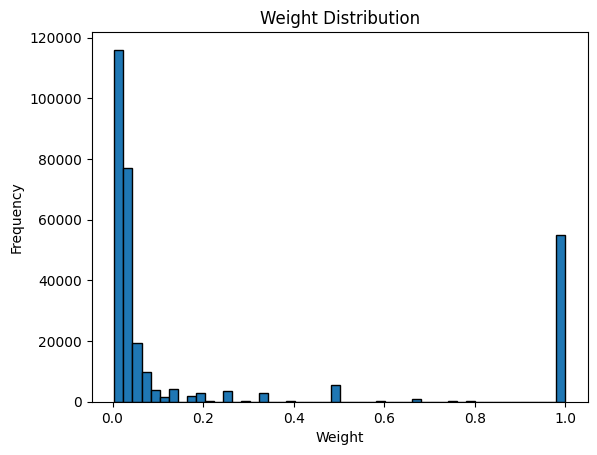

In [27]:
import matplotlib.pyplot as plt

weights = s_edges_with_weight.select("weight").collect().to_numpy().flatten()
plt.hist(weights, bins=50, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Distribution')
plt.show()

Text(0.5, 1.0, "P vs P' Distribution")

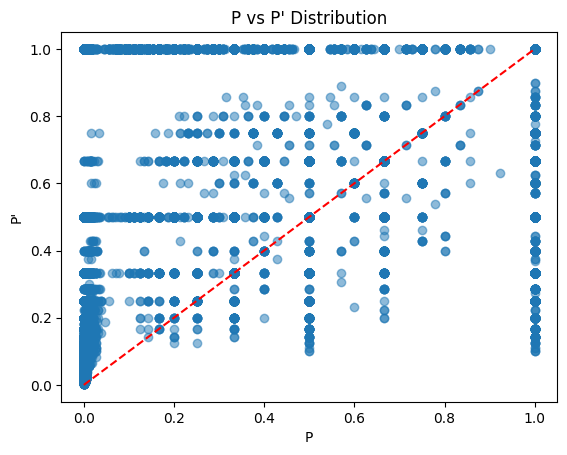

In [28]:
# P vs P_prime scatter plot (should see which dominates)
data = s_edges_with_weight.select(["P", "P_prime", "weight"]).collect()
plt.scatter(data["P"], data["P_prime"], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
plt.xlabel('P')
plt.ylabel("P'")
plt.title("P vs P' Distribution")

In [29]:
s_edges_with_weight.collect()

v_s,v_d,spec_count,s_to_any,any_to_d,P,P_prime,weight
str,str,u32,u32,u32,f64,f64,f64
"""806152370->806BCD840""","""806BCD840->8070B0B80""",1,1,1,1.0,1.0,1.0
"""800AFF350->1004286A8""","""1004286A8->810F3E8C0""",1,672,8,0.001488,0.125,0.125
"""80218C960->1004286A8""","""1004286A8->806805780""",1,1337,33,0.000748,0.030303,0.030303
"""80E68A590->1004286A8""","""1004286A8->802F16290""",1,1131,27,0.000884,0.037037,0.037037
"""803B93700->805A65630""","""805A65630->805B375D0""",1,2,2,0.5,0.5,0.5
…,…,…,…,…,…,…,…
"""806018480->100428660""","""100428660->80971E5A0""",1,2045,63,0.000489,0.015873,0.015873
"""80019DE00->80F7CDB10""","""80F7CDB10->81195CC90""",2,2,2,1.0,1.0,1.0
"""8131F0060->1004286A8""","""1004286A8->8019BD7D0""",1,1366,25,0.000732,0.04,0.04


### Apply second order graph's weight to Temporal graph's edges

In [85]:
edges_with_weight = edges.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i")], separator="->").alias("tx_s"),
    pl.concat_str([pl.col("b_i"), pl.col("b_i_d")], separator="->").alias("tx_d")
]).join(
    s_edges_with_weight.select([
        "v_s", "v_d", "weight"
    ]),
    left_on=["tx_s", "tx_d"],
    right_on=["v_s", "v_d"],
    how="left"
# )
).drop([
    "tx_s", "tx_d"
])

## Community Detection with Leiden

In [87]:
edges_with_weight.collect().filter(pl.col("Is Laundering") == 1)

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d,weight
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64,f64
127771,"""100428660""","""800704A30""",2022-09-06 16:52:00,7093.06,1,6361,"""809031710""",2022-09-07 09:52:00,212.95,0,1.0
99487,"""80AEB33D0""","""80AEB4990""",2022-09-04 13:26:00,862.64,1,13771,"""80AEB4990""",2022-09-05 13:22:00,4.24,0,0.666667
316407,"""80018E990""","""800059C00""",2022-09-08 13:14:00,6742.83,1,23134,"""80018E990""",2022-09-08 14:22:00,1518.21,0,0.5
5509,"""8001BB380""","""8001A6870""",2022-09-01 17:48:00,1499.02,1,24864,"""8016C6620""",2022-09-01 20:46:00,29.05,0,1.0
132494,"""804B56250""","""807C35490""",2022-09-06 14:55:00,4445.55,1,26405,"""808B09840""",2022-09-07 12:53:00,1223.72,0,1.0
…,…,…,…,…,…,…,…,…,…,…,…
151,"""8021353D0""","""80266F880""",2022-09-09 09:47:00,14368.04,1,436680,"""80286DE40""",2022-09-10 02:27:00,9783.49,0,0.5
45909,"""8061A6010""","""806C62690""",2022-09-06 13:24:00,832531.23,1,441738,"""8073A2C80""",2022-09-07 04:14:00,3.6226e6,0,1.0
240520,"""80777E5C0""","""800E3D880""",2022-09-06 17:05:00,4264.34,1,442701,"""808173600""",2022-09-07 06:36:00,1135.38,0,1.0


In [88]:
edges_with_weight.collect().filter(pl.col("Is Laundering") == 1)["weight"].value_counts().sort("weight")

weight,count
f64,u32
0.333333,1
0.5,9
0.666667,2
1.0,84


In [89]:
edges_with_weight.collect().filter(pl.col("Is Laundering") == 0)["weight"].value_counts().sort("weight")

weight,count
f64,u32
0.004202,20
0.004329,12
0.00463,18
0.005155,63
0.005319,25
…,…
0.857143,66
0.875,21
0.888889,8


In [90]:
df_for_leiden = edges_with_weight.select([
    pl.concat_str(["f_i", "b_i", "t_i"]).alias("source_node"),
    pl.concat_str(["b_i", "b_i_d", "t_i_d"]).alias("target_node"),
    pl.col("weight")
])

In [91]:
df_for_leiden.collect()

source_node,target_node,weight
str,str,f64
"""81269FE501004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
"""8070EAE501004286602022-09-02 1…","""100428660800C08F102022-09-02 1…",0.041667
"""8060184801004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
"""80D167C201004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
"""80C710A101004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
…,…,…
"""8137529A1813B87B712022-09-06 0…","""813B87B71813B87B712022-09-06 2…",1.0
"""8093BB6401004286A82022-09-02 0…","""1004286A88144DAE902022-09-02 0…",0.25
"""80E2EFCF01004286A82022-09-02 0…","""1004286A88144DAE902022-09-02 0…",0.25


In [92]:
df_for_leiden_with_weight_filtered = df_for_leiden.filter(pl.col("weight") >= 0.5)

In [93]:
df_for_leiden_with_weight_filtered.collect()

source_node,target_node,weight
str,str,f64
"""8001A84608001E5B002022-09-08 0…","""8001E5B00800A36BC02022-09-08 1…",1.0
"""80979071080F2938C02022-09-08 1…","""80F2938C08104648502022-09-09 0…",1.0
"""800284530800798B002022-09-06 1…","""800798B008009E68A02022-09-07 1…",1.0
"""8005DBC308017C91C02022-09-07 1…","""8017C91C0802E2DAE02022-09-08 1…",1.0
"""8090F74E08091977702022-09-01 1…","""80919777080924BA002022-09-02 0…",1.0
…,…,…
"""80E1A3C5080E23FCD02022-09-01 1…","""80E23FCD080E7EB7E02022-09-02 1…",1.0
"""80E868AD080F1238A02022-09-01 2…","""80F1238A080F479BB02022-09-02 0…",1.0
"""80E868AD080F1238A02022-09-02 0…","""80F1238A080F479BB02022-09-02 0…",1.0


In [94]:
edges_data = df_for_leiden_with_weight_filtered.select([
    "source_node", "target_node", "weight"
]).collect().to_numpy()

In [95]:
g = ig.Graph.TupleList(edges_data, directed=True, weights=True)

In [96]:
partition = g.community_leiden(weights='weight', objective_function='modularity')

In [97]:
partition

In [98]:
# Create a mapping of Transaction ID -> Community ID
node_names = g.vs["name"]
community_ids = partition.membership

community_df = pl.LazyFrame({
    "node_id_str": node_names,
    "community_id": community_ids
})

# Now you can join this back to your original transaction data to see the "Fraud Rings"

In [111]:
community_df.collect().head()

node_id_str,community_id
str,i64
"""8001A84608001E5B002022-09-08 0…",0
"""8001E5B00800A36BC02022-09-08 1…",0
"""80979071080F2938C02022-09-08 1…",1
"""80F2938C08104648502022-09-09 0…",1
"""800284530800798B002022-09-06 1…",2


## Anomalous Communities Detection

### Applying Community ID back to Temporal Node

In [100]:
nodes_with_community = nodes.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i"), pl.col("t_i")]).alias("node_id_str")
]).join(
    community_df,
    on="node_id_str",
    how="left"
).drop("node_id_str")

In [113]:
nodes_with_community.collect()

node_id,f_i,b_i,t_i,a_i,Is Laundering,community_id
u32,str,str,datetime[μs],f64,i64,i64
0,"""808376670""","""808763050""",2022-09-01 14:51:00,165.58,0,null
1,"""100428660""","""800C08F10""",2022-09-02 12:05:00,1000.0,0,30848
2,"""8035A5A50""","""8035CB140""",2022-09-07 22:23:00,4449.0,0,null
3,"""8028B20E0""","""80B5A8EF0""",2022-09-02 15:44:00,24022.22,0,null
4,"""803109B90""","""80A633740""",2022-09-01 00:28:00,2777.01,0,null
…,…,…,…,…,…,…
459751,"""813B87B71""","""813B87B71""",2022-09-06 20:48:00,0.026602,0,41891
459752,"""1004286A8""","""8144DAE90""",2022-09-02 01:05:00,1614.02,0,null
459753,"""8085123D0""","""80F2F2D50""",2022-09-09 12:46:00,320.56,0,null


In [102]:
#count nodes that has community_id not null
nodes_with_community.collect().filter(pl.col("community_id").is_not_null()).shape, nodes_with_community.collect().filter(pl.col("community_id").is_null()).shape

((120244, 7), (339512, 7))

In [103]:
# group by account in f_i and b_i to see how many unique community ids each account is involved in
f_i_communities = nodes_with_community.select([
    pl.col("f_i").alias("account"),
    pl.col("community_id")
]).filter(pl.col("community_id").is_not_null()
).unique().group_by("account").agg([
    pl.col("community_id").n_unique().alias("unique_communities")
])

b_i_communities = nodes_with_community.select([
    pl.col("b_i").alias("account"),
    pl.col("community_id")
]).filter(pl.col("community_id").is_not_null()).unique().group_by("account").agg([
    pl.col("community_id").n_unique().alias("unique_communities")
])

In [104]:
# merge f_i and b_i community counts
account_communities = pl.concat([f_i_communities, b_i_communities]).group_by("account").agg([
    pl.col("unique_communities").sum().alias("total_unique_communities")
])

In [105]:
account_communities.collect().shape

(89227, 2)

In [106]:
# count accounts in original df
unique_acc_left = df.select(pl.col("Account")).unique().collect().shape
unique_acc_right = df.select(pl.col("Account_duplicated_0")).unique().collect().shape

all_accounts = pl.concat([
    df.select(pl.col("Account").alias("account")),
    df.select(pl.col("Account_duplicated_0").alias("account"))
]).unique().collect()

In [107]:
all_accounts.shape

(243610, 1)

### Community features extraction

In [115]:
edges_out_degrees = edges_with_weight.with_columns([
    pl.col("v_s").alias("node_id")
]).group_by("node_id").agg([
    pl.len().alias("out_degree")
])

edges_in_degrees = edges_with_weight.with_columns([
    pl.col("v_d").alias("node_id")
]).group_by("node_id").agg([
    pl.len().alias("in_degree")
])

In [116]:
edges_in_degrees.collect().head()

node_id,in_degree
u32,u32
98182,1
110252,31
1587,1
194670,27
196891,1


In [172]:
edges_features = edges_with_weight.join(
    nodes_with_community.select([
        pl.col("node_id").alias("v_s"),
        pl.col("community_id").alias("community_id_s")
    ]),
    how="left",
    on="v_s"
).join(
    nodes_with_community.select([
        pl.col("node_id").alias("v_d"),
        pl.col("community_id").alias("community_id_d")
    ]),
    how="left",
    on="v_d"
).filter(
    pl.col("community_id_s") == pl.col("community_id_d")
).drop([
    "community_id_d"
])

In [173]:
edges_with_weight.collect().shape, edges_features.collect().shape

((350964, 12), (83395, 13))

In [174]:
edges_features = edges_features.join(
    edges_in_degrees,
    left_on="v_d",
    right_on="node_id",
    how="left"
# )
).join(
    edges_out_degrees,
    left_on="v_s",
    right_on="node_id",
    how="left"
)

In [175]:
edges_features.collect().head()

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d,weight,community_id_s,in_degree,out_degree
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64,f64,i64,u32,u32
380127,"""8001A8460""","""8001E5B00""",2022-09-08 07:32:00,1202.35,0,45,"""800A36BC0""",2022-09-08 18:37:00,93.81,0,1.0,0,1,3
46699,"""809790710""","""80F2938C0""",2022-09-08 10:00:00,1763.79,0,53,"""810464850""",2022-09-09 02:16:00,2004.7,0,1.0,1,1,1
153155,"""800284530""","""800798B00""",2022-09-06 17:02:00,21488.14,0,56,"""8009E68A0""",2022-09-07 10:45:00,1544.66,0,1.0,2,1,3
404989,"""8005DBC30""","""8017C91C0""",2022-09-07 19:40:00,3008.47,0,60,"""802E2DAE0""",2022-09-08 14:45:00,19.32,0,1.0,3,1,1
134996,"""8090F74E0""","""809197770""",2022-09-01 13:37:00,15032.99,0,62,"""80924BA00""",2022-09-02 07:04:00,5096.54,0,1.0,4,1,2


In [176]:
edges_features = edges_features.group_by("community_id_s").agg([
    pl.len().alias("num_edges"),
    pl.col("weight").mean().alias("avg_edge_weight"),
    pl.col("in_degree").sum().alias("total_in_degree"),
    pl.col("out_degree").sum().alias("total_out_degree"),
]).rename({
    "community_id_s": "community_id"
})

In [177]:
edges_features.collect().head()

community_id,num_edges,avg_edge_weight,total_in_degree,total_out_degree
i64,u32,f64,u32,u32
18766,5,1.0,7,11
34891,1,1.0,1,1
15095,2,1.0,2,2
22288,1,1.0,1,1
15744,1,1.0,1,1


In [183]:
nodes_with_community.collect().head()

node_id,f_i,b_i,t_i,a_i,Is Laundering,community_id
u32,str,str,datetime[μs],f64,i64,i64
0,"""808376670""","""808763050""",2022-09-01 14:51:00,165.58,0,null
1,"""100428660""","""800C08F10""",2022-09-02 12:05:00,1000.0,0,30848
2,"""8035A5A50""","""8035CB140""",2022-09-07 22:23:00,4449.0,0,null
3,"""8028B20E0""","""80B5A8EF0""",2022-09-02 15:44:00,24022.22,0,null
4,"""803109B90""","""80A633740""",2022-09-01 00:28:00,2777.01,0,null


In [180]:
# aggregate community features including number of transactions in each community, number of edges, total / average amount, average edge weight, in/out degree
community_features = nodes_with_community.group_by("community_id").agg([
    pl.len().alias("transactions_count"),
    pl.sum("a_i").alias("total_amount"),
    pl.mean("a_i").alias("average_amount")
]).join(
    edges_features,
    left_on="community_id",
    right_on="community_id",
    how="left"
)
    

In [182]:
community_features.collect().shape

(41893, 8)

In [181]:
community_features.collect().head()

community_id,transactions_count,total_amount,average_amount,num_edges,avg_edge_weight,total_in_degree,total_out_degree
i64,u32,f64,f64,u32,f64,u32,u32
22038,2,611871.18,305935.59,1,1.0,1,1
16536,4,12384.59,3096.1475,3,1.0,3,5
10492,3,255.54,85.18,2,1.0,2,4
20597,2,1059.98,529.99,1,1.0,1,1
14967,6,152143.97,25357.328333,6,1.0,8,12


---